In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

In [3]:
data = pd.read_csv("mustapp_reviews_total.csv")

In [4]:
data['Sentiment'] = data['Rating'].apply(lambda x: 1 if x >= 7 else 0)

In [5]:
data

,Mustapp page ID,Name,Description,Review,Rating,Sentiment
0,1,Ариэль,"Таисто, шахтёр из Лапландии, остаётся без рабо...",Фильм показывает нестабильную среду простых л...,8,1
1,1,Ариэль,"Таисто, шахтёр из Лапландии, остаётся без рабо...",Простые люди попадают в непростые обстоятельст...,8,1
2,2,Тени в раю,NaN,В Финляндии более мрачные Патерсоны\n,7,1
3,2,Тени в раю,NaN,Minimalistic with words but still full of mean...,8,1
4,2,Тени в раю,NaN,"Просто, приземленно, обыденно, заурядно и имен...",8,1
...,...,...,...,...,...,...
177505,19992,Doraemon: Nobita's the Legend of the Sun King,Doraemon and its friends open a hole in the ti...,jodete ledinapoporu te quiero \n,8,1
177506,19992,Doraemon: Nobita's the Legend of the Sun King,Doraemon and its friends open a hole in the ti...,Todas las peliculas de doraemon son buenas lo ...,10,1
177507,19997,Waiting to Exhale,NaN,"It's good, but could be better...\n",7,1
177508,19997,Waiting to Exhale,NaN,Cute ‘95 chick flick. I love Whitney Houstonnn...,5,0


# SVM

In [6]:
data_clean = data.copy()

In [7]:
def count_russian_chars(s: str) -> int:
    return len(re.findall(r'[а-яА-Я]', s))

data_clean['Russian chars'] = data_clean['Review'].apply(lambda x: count_russian_chars(str(x)))

In [8]:
data_clean_russian = data_clean[data_clean['Russian chars'] > 0]
data_clean_russian = data_clean_russian.reset_index(drop=True)

In [9]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

stemmer = SnowballStemmer("russian")

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    words = word_tokenize(text, language="russian")
    words = [stemmer.stem(word) for word in words]
    return " ".join(words)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gfgh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\gfgh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gfgh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
data_clean_russian['Review'] = data_clean_russian['Review'].apply(lambda x: preprocess_text(str(x)))
print(data_clean_russian.head())

   Mustapp page ID        Name  \
0                1      Ариэль   
1                1      Ариэль   
2                2  Тени в раю   
3                2  Тени в раю   
4                2  Тени в раю   

                                         Description  \
0  Таисто, шахтёр из Лапландии, остаётся без рабо...   
1  Таисто, шахтёр из Лапландии, остаётся без рабо...   
2                                                NaN   
3                                                NaN   
4                                                NaN   

                                              Review  Rating  Sentiment  \
0  фильм показыва нестабильн сред прост люд переб...       8          1   
1  прост люд попада в непрост обстоятельств холод...       8          1   
2                       в финлянд бол мрачн патерсон       7          1   
3  прост приземлен обыден заурядн и имен поэт так...       8          1   
4                           фин кур minutes straight       8          1   

   Russ

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_clean_russian[['Review']],
                                                    data_clean_russian['Sentiment'],
                                                    stratify=data_clean_russian['Sentiment'],
                                                    test_size=0.25,
                                                    random_state=42)

In [12]:
pipeline = Pipeline([
    ('tf-idf', TfidfVectorizer(ngram_range=(1,3))),
    ('clf', SVC(C=1, kernel='linear'))
])

In [13]:
pipeline.fit(X_train['Review'], y_train)

Pipeline(steps=[('tf-idf', TfidfVectorizer(ngram_range=(1, 3))),
                ('clf', SVC(C=1, kernel='linear'))])

In [14]:
pred = pipeline.predict(X_test['Review'])
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.70      0.43      0.53      6965
           1       0.86      0.95      0.90     25470

    accuracy                           0.84     32435
   macro avg       0.78      0.69      0.72     32435
weighted avg       0.82      0.84      0.82     32435



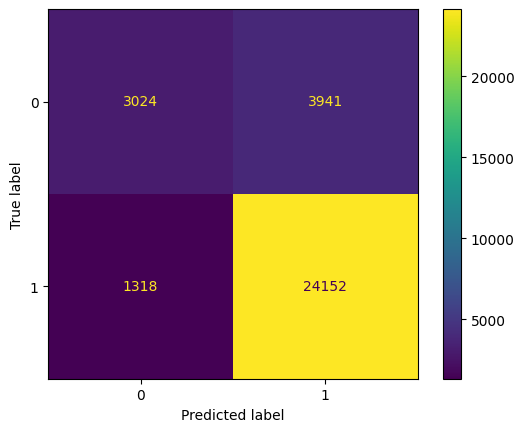

In [15]:
_ = ConfusionMatrixDisplay.from_estimator(pipeline, X_test['Review'], y_test)

Добавим немного экспериментов с параметрами! Попробуем перейти на другое ядро - rbf, а также поиграться с параметром C.

In [16]:
X_train, X_test, y_train, y_test = train_test_split(data_clean_russian[['Review']],
                                                    data_clean_russian['Sentiment'],
                                                    stratify=data_clean_russian['Sentiment'],
                                                    test_size=0.25,
                                                    random_state=42)

C = 1
              precision    recall  f1-score   support

           0       0.76      0.32      0.45      6965
           1       0.84      0.97      0.90     25470

    accuracy                           0.83     32435
   macro avg       0.80      0.65      0.68     32435
weighted avg       0.82      0.83      0.80     32435



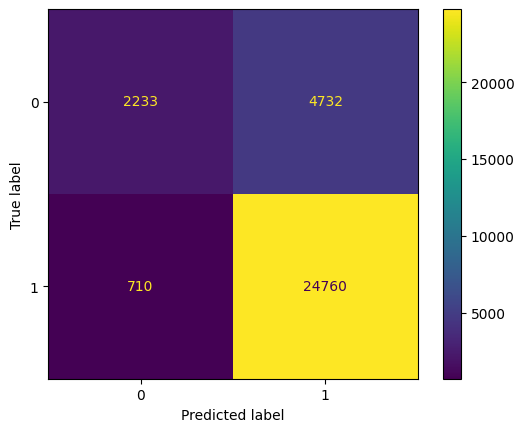

In [17]:
pipeline = Pipeline([
    ("tf-idf", TfidfVectorizer(ngram_range=(1, 3))),
    ("clf", SVC(C=1, kernel="rbf"))
])

print('='*50)
print("C = 1")
pipeline.fit(X_train["Review"], y_train)
pred = pipeline.predict(X_test["Review"])
print(classification_report(y_test, pred))
_ = ConfusionMatrixDisplay.from_estimator(pipeline, X_test["Review"], y_test)
print('='*50)

C = 10
              precision    recall  f1-score   support

           0       0.70      0.43      0.53      6965
           1       0.86      0.95      0.90     25470

    accuracy                           0.84     32435
   macro avg       0.78      0.69      0.72     32435
weighted avg       0.82      0.84      0.82     32435



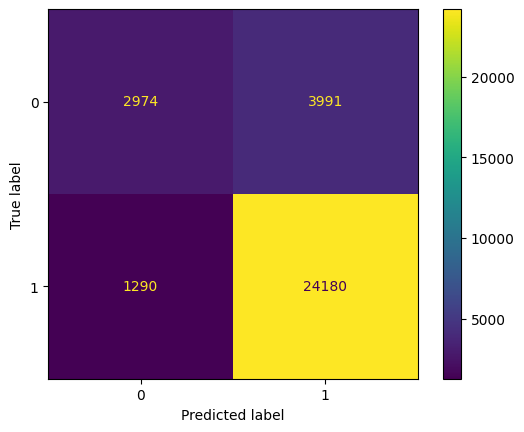

In [18]:
pipeline = Pipeline([
    ("tf-idf", TfidfVectorizer(ngram_range=(1, 3))),
    ("clf", SVC(C=10, kernel="rbf"))
])

print('='*50)
print("C = 10")
pipeline.fit(X_train["Review"], y_train)
pred = pipeline.predict(X_test["Review"])
print(classification_report(y_test, pred))
_ = ConfusionMatrixDisplay.from_estimator(pipeline, X_test["Review"], y_test)
print('='*50)

# Итоги

## Linear kernel

              precision    recall  f1-score   support

           0       0.70      0.43      0.53      6965
           1       0.86      0.95      0.90     25470

## RBF kernel

* C = 1

              precision    recall  f1-score   support

           0       0.76      0.32      0.45      6965
           1       0.84      0.97      0.90     25470

* C = 10

              precision    recall  f1-score   support

           0       0.70      0.43      0.53      6965
           1       0.86      0.95      0.90     25470